In [2]:
import sys
sys.path.append("../")
from CreacionModeloVelocidad import ModeloVelocidad
from propagator import propagator
from pytictoc import TicToc

import numpy as np
import matplotlib.pyplot as plt

In [3]:
#%% Parametros de la propagación
fq = 16   # Frecuencia (Hz)
nz = 150  # Puntos del modelo en z
nx = nz * 3  # Puntos del modelo en x (en specfem es 100)
nt = 800  # Puntos del modelo en t
tipo_fuente = "gaussian_neg" # gaussian, ricker, gaussian_neg

n_abs = 30  # nodos para absorber condiciones de frontera en ambas direcciones
# n_abs = 20  # nodos para absorber condiciones de frontera en ambas direcciones
n_absx = n_abs  # nodos del lado izquierdo del dominio
n_absz = n_abs  # el límite superior no absorbe

n_event = 1  # numero de eventos sísmicos

ax_spec = 1.5  # tamaño del dominio antes de eliminar las regiones absorbentes
az_spec = 0.5
xsf = 1.3  # ubicación en x de todos los sismómetros

dh = ax_spec / nx  # Tamaño de la celda
dx = dz = dh
dt = dh * 1000 / (np.amax(3000) * np.sqrt(2))  # Intervalo temporal

# Coordenadas de la fuente (en indices de la matriz)
sx = int(nx / 3)
sz = int(nz / 2)

# Dimensión del dominio para entrenamiento de PINNs.
ax = xsf - n_absx * dx
# solo se elimina el grosor del la frontera absorbente de la izquierda ya que #xsf es (debe ser) más pequeño que donde comienza la frontera absorbente del lado derecho.
az = az_spec - n_absz * dz 

xxs, zzs = np.meshgrid(np.linspace(0, nx, nx), np.linspace(0,nz, nz))

In [4]:
# Modelo de velocidad
velocidad = ModeloVelocidad(nx, nz, dx, dz, sx, sz)

# Modelo de Rash
alpha_true1 = velocidad.cargar_modelo_rash("../event1/modelo_vel.npy", ax/dx, az/dz, order=1, mode="edge")
alpha_true1 = alpha_true1.T

In [6]:
alpha_true1 = np.ones((nx,nz))*3000

In [7]:
# Ejecución de la propagación
ttic = TicToc()
ttic.tic()
P = propagator(alpha_true1, sx, sz, dx*1000, dz*1000, dt, nt, 10e3, fq, "gaussian_neg", ["left", "right", "top", "bottom"])
ttic.toc()

Elapsed time is 11.991674 seconds.


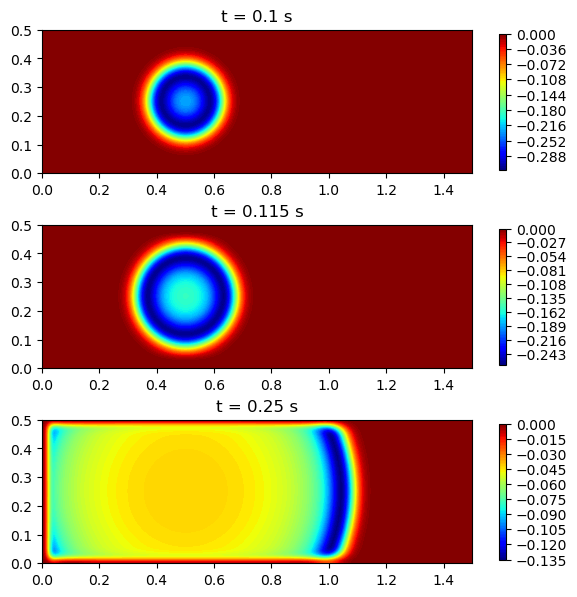

In [8]:
#%% 
t01 = 0.1
t02 = 0.115
t_la = 0.25

time_list = [t01, t02, t_la]

t_index = [int(time / dt) for time in time_list]

fig, axs = plt.subplots(3,1, figsize=(6, 6))
for i, t in enumerate(t_index):
    campo = P[:,:,t]
    ax = axs[i]

    im = ax.contourf(xxs * dx, zzs * dz, campo.T, 100, cmap="jet")
    ax.set_title(f"t = {time_list[i]} s")
    ax.axis("scaled")
    plt.colorbar(im, ax=ax, shrink=0.92)

fig.tight_layout()
plt.show()

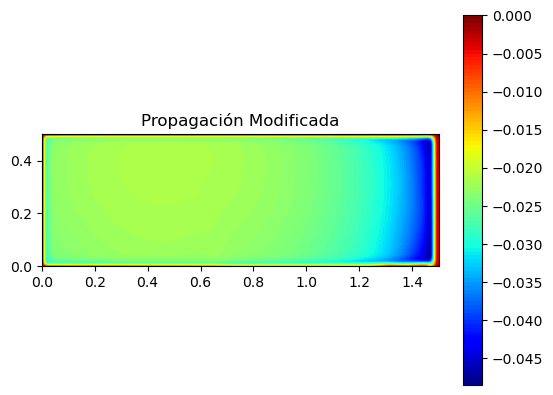

In [13]:
campo = P[:,:,550]

plt.figure()
plt.contourf(xxs * dx, zzs * dz, campo.T, 100, cmap="jet")
plt.colorbar()
plt.title("Propagación Modificada")
plt.axis("scaled")
plt.show()